In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import logging
import os
import holidays
from sklearn.linear_model import LinearRegression

In [2]:
# Define logger
logging.basicConfig(
    level=logging.INFO,
    handlers=[logging.StreamHandler()],
    format="%(asctime)s [%(levelname)s] %(message)s",
)

logger = logging.getLogger(__name__)

In [3]:
# DB config
POSTGRES_DB = "postgres"
POSTGRES_HOST = "localhost"
POSTGRES_USER = "postgres"
POSTGRES_PASSWORD = "postgres"

DB_URI = f"postgresql+psycopg2://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}/{POSTGRES_DB}"

try:
    logger.info('Creating Connection to DB...')
    db_engine = create_engine(DB_URI)
    logger.info('Connection to DB established')
except Exception as e:
    logger.error('Error while connecting to DB')
    logger.error(e)

2022-04-14 16:05:16,022 [INFO] Creating Connection to DB...
2022-04-14 16:05:16,073 [INFO] Connection to DB established


## Exercise 1

In [4]:
BASE_OUTPUT_PATH = os.path.join(os.getcwd(), 'output')

if not os.path.isdir(BASE_OUTPUT_PATH):
    os.mkdir(BASE_OUTPUT_PATH)

In [5]:
last_30_days_coin_prices = pd.read_sql_query("""
SELECT 
    date,
    coin_id,
    price
FROM coin_raw
WHERE date > CAST(now() AS DATE) - 30
""", db_engine)

last_30_days_coin_prices = last_30_days_coin_prices.set_index("date")

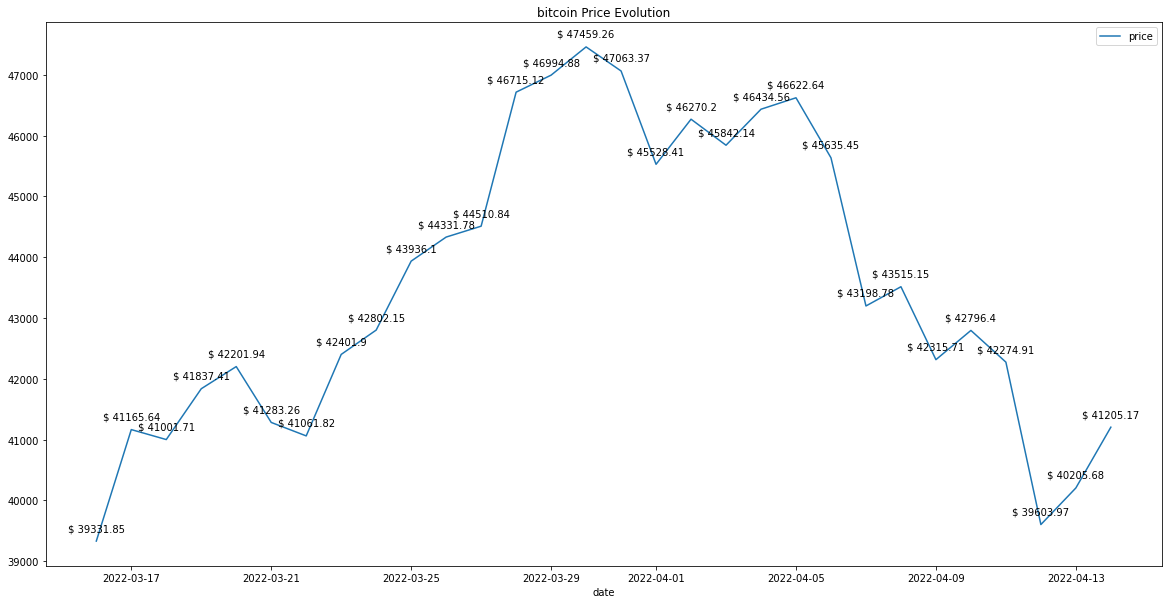

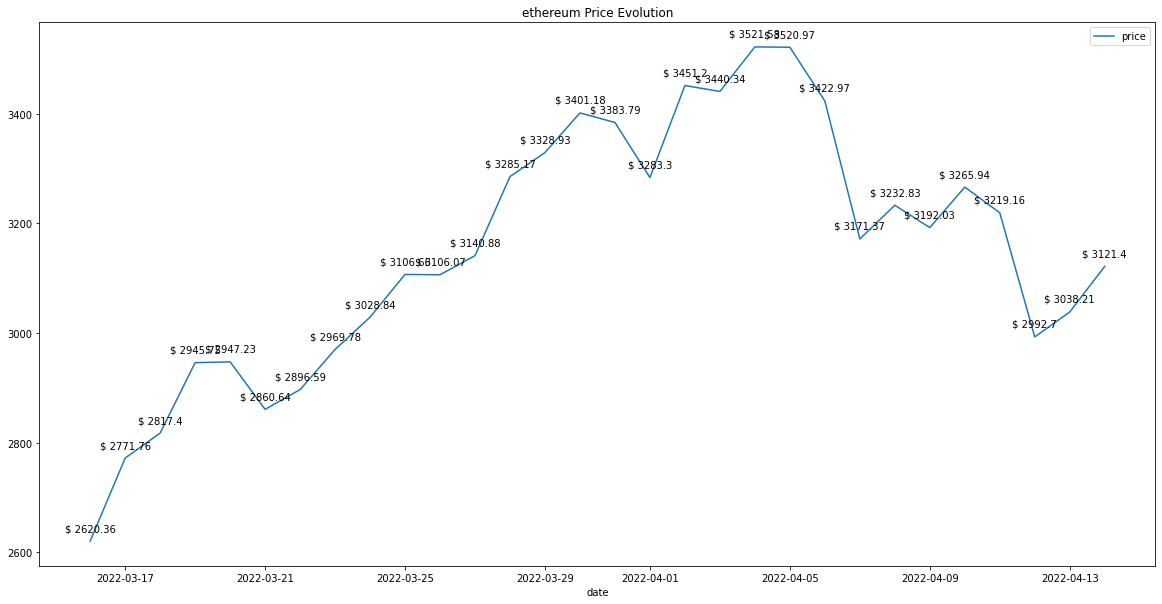

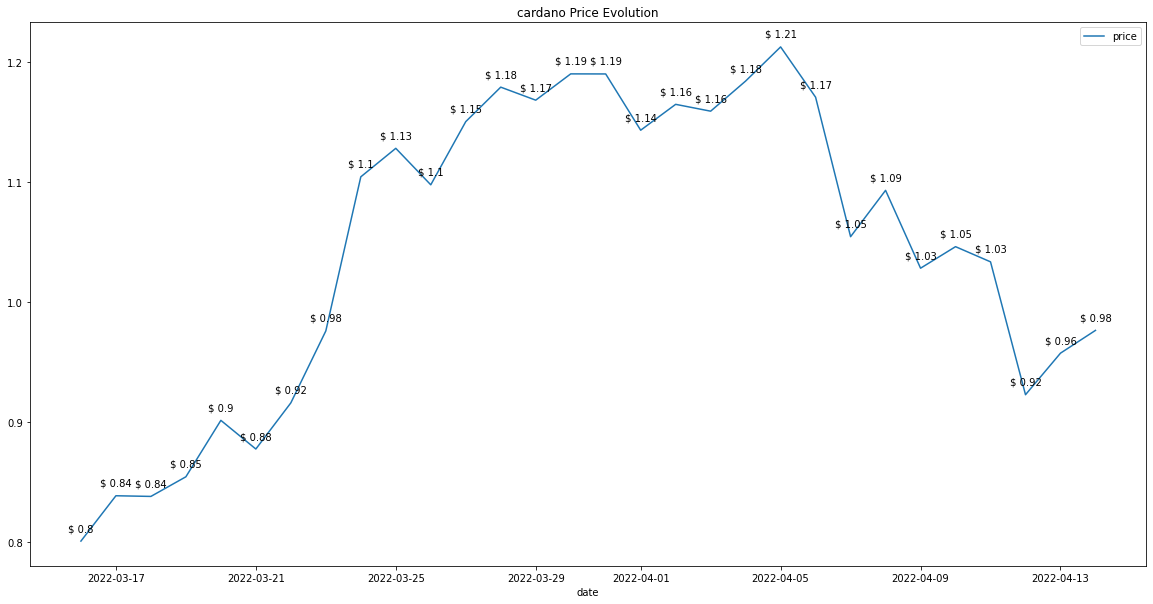

In [6]:
COINS = last_30_days_coin_prices.coin_id.unique()

for coin in COINS:

    plot_data = last_30_days_coin_prices.query(f"coin_id == '{coin}'")
    ax = plot_data.plot(
        figsize=(20, 10),
        title=f"{coin} Price Evolution",
    )

    for x, y in zip(plot_data.index, plot_data.price):
        ax.annotate(
            f"$ {round(y, 2)}",
            (x, y),
            textcoords="offset points",
            xytext=(0, 10),
            ha="center",
        )
        
    plt.savefig(f"{BASE_OUTPUT_PATH}/{coin}_plot.png")

## Exercise 2

In [7]:
coin_raw = pd.read_sql_query("SELECT * FROM coin_raw ORDER BY coin_id, date", db_engine).set_index(['coin_id', 'date'])

In [8]:
# Created shifted DF and then join it to coin_raw DF
coin_raw_shifted_1_day = coin_raw.groupby(level="coin_id").shift(1)[['price']]
coin_raw_shifted_1_day.columns = [f"{x}_d1" for x in coin_raw_shifted_1_day.columns]

coin_raw_shifted_2_days = coin_raw.groupby(level="coin_id").shift(2)[['price']]
coin_raw_shifted_2_days.columns = [f"{x}_d2" for x in coin_raw_shifted_2_days.columns]

coin_raw_merged = coin_raw.merge(
        coin_raw_shifted_1_day, 
        how='inner', 
        left_index=True, 
        right_index=True).merge(
        coin_raw_shifted_2_days, 
        how='inner', 
        left_index=True, 
        right_index=True)

coin_raw_merged['price_diff'] = coin_raw_merged.price / coin_raw_merged.price_d2
coin_raw_merged = coin_raw_merged.reset_index(drop=False)


In [9]:
def get_risk_coin_level(df):
    """Function to get the Coin Risk Level"""
    if (np.nanmin(df.price_diff)) <= 0.5:
        risk_level = 'High Risk'
        
    elif (np.nanmin(df.price_diff)) <= 0.8:
        risk_level = 'Medium Risk'
    
    else:
        risk_level = 'Low Risk'
        
    return risk_level


In [10]:
# Apply and get each Coin Risk Level, and join it again to coin_raw_merged DF
coins_riks_levels = coin_raw_merged.reset_index(drop=False).groupby('coin_id').apply(
    lambda x: get_risk_coin_level(x)).reset_index(drop=False)

coins_riks_levels.columns = ['coin_id', 'risk_level']
coins_riks_levels = coins_riks_levels.set_index('coin_id')

coin_raw_merged_with_risk_level = coin_raw_merged.merge(
    coins_riks_levels, 
    how='inner', 
    on='coin_id'
)


In [11]:
# Add 7 day price trend and variance for each coin
coin_raw_merged_with_risk_level['r7_price_trend'] = coin_raw_merged_with_risk_level.groupby(['coin_id']).rolling(7)['price'].mean().reset_index(drop=False)[['price']]
coin_raw_merged_with_risk_level['r7_price_variance'] = coin_raw_merged_with_risk_level.groupby(['coin_id']).rolling(7)['price'].var().reset_index(drop=False)[['price']]


## Exercise 3

In [12]:
# Add 7 last price points for each coin
for i in range(7):
    coin_raw_merged_with_risk_level[f'price_d{i+1}'] = coin_raw_merged_with_risk_level.groupby("coin_id").shift(i+1)[['price']]
    
# Add following day price
coin_raw_merged_with_risk_level['price_f1'] = coin_raw_merged_with_risk_level.groupby("coin_id").shift(-1)[['price']]


In [13]:
# Add date related features
coin_raw_merged_with_risk_level['month'] = coin_raw_merged_with_risk_level.date.dt.month
coin_raw_merged_with_risk_level['day'] = coin_raw_merged_with_risk_level.date.dt.day
coin_raw_merged_with_risk_level['day_of_week'] = coin_raw_merged_with_risk_level.date.dt.day_of_week
coin_raw_merged_with_risk_level['weekend'] = [1 if x in [5, 6] else 0 for x in coin_raw_merged_with_risk_level['day_of_week']]



In [14]:
def extract_volume_from_response(df):
    """Function to extract the transacted volume from the response JSON"""
    return df.response['market_data']['total_volume']['usd']


# Add features related to volume transacted
coin_raw_merged_with_risk_level['volume'] = coin_raw_merged_with_risk_level.apply(lambda x: extract_volume_from_response(x), axis=1)

# Add 7 last volume transacted points for each coin
for i in range(7):
    coin_raw_merged_with_risk_level[f'volume_d{i+1}'] = coin_raw_merged_with_risk_level.groupby("coin_id").shift(i+1)[['volume']]
    

In [15]:
def check_holidays(country_holidays, date):
    if date in us_holidays:
        return 1
    else:
        return 0

# Add columns related to US and China holidays
us_holidays = holidays.country_holidays('US')
coin_raw_merged_with_risk_level['us_holiday'] = coin_raw_merged_with_risk_level.apply(lambda x: check_holidays(us_holidays, x.date), axis=1)

cn_holidays = holidays.country_holidays('CN')
coin_raw_merged_with_risk_level['cn_holiday'] = coin_raw_merged_with_risk_level.apply(lambda x: check_holidays(cn_holidays, x.date), axis=1)



## Exercise 4
For the following time series model, I am just going to use the price features, and the weekend and holiday ones. I am not using anything else, since I would also have to forecast them when validating the model.

The idea is to build a model for each coin with the data from `2020-01-01` until `2021-12-31` and forecast the values from `2022-01-01` to `2022-04-14` and compare it with the real ones. 

As I am using the previuos 7 prices as an input to the model, I will use a recursive multi step forecasting strategy (when forecasting I have to use the result from the previous predictions).

To solve this time series analysis, I am going to use a simple `LinearRegression` from `sklearn`.

In [57]:
MODEL_OUTPUT_PATH = os.path.join(os.getcwd(), 'model_output')

if not os.path.isdir(MODEL_OUTPUT_PATH):
    os.mkdir(MODEL_OUTPUT_PATH)

In [22]:
model_data = coin_raw_merged_with_risk_level[
    ['date', 'coin_id', 'price', 'price_f1', 
     'price_d1', 'price_d2', 'price_d3', 'price_d4', 'price_d5', 'price_d6', 'price_d7',
     #'month', 'day', 'day_of_week', 'weekend', 'us_holiday', 'cn_holiday']
     'weekend', 'us_holiday', 'cn_holiday']
]

model_data = model_data.dropna().reset_index(drop=True)


/var/folders/5f/vypnw_wd70zc1bkxjqxw5sc00000gp/T/ipykernel_7295/315596482.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['pred'] = predictions
/var/folders/5f/vypnw_wd70zc1bkxjqxw5sc00000gp/T/ipykernel_7295/315596482.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['real'] = y_test
/var/folders/5f/vypnw_wd70zc1bkxjqxw5sc00000gp/T/ipykernel_7295/315596482.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

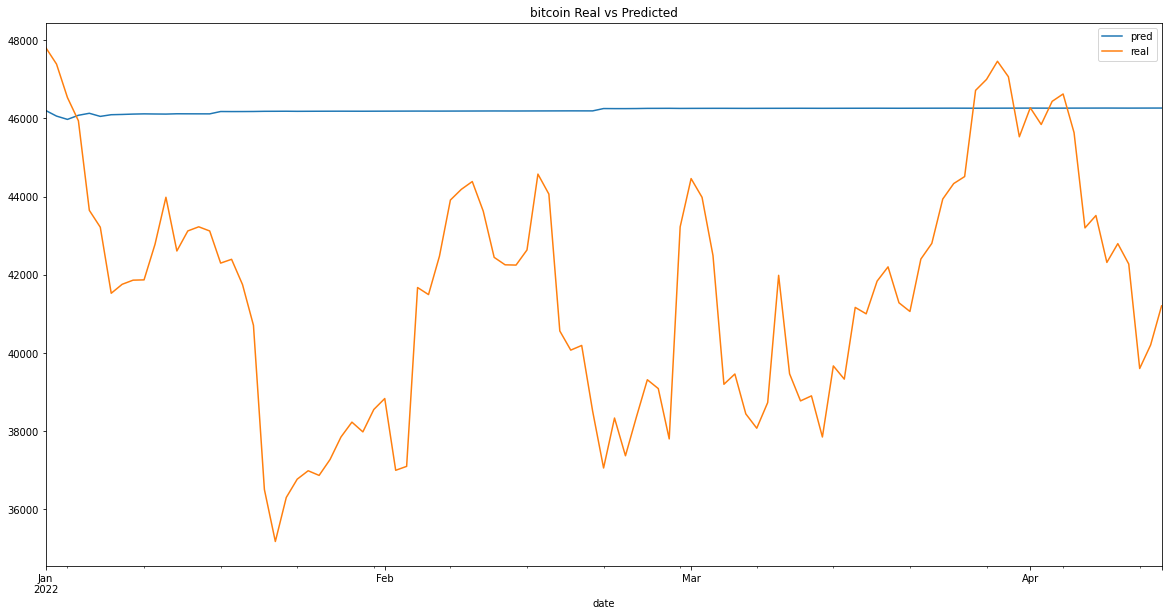

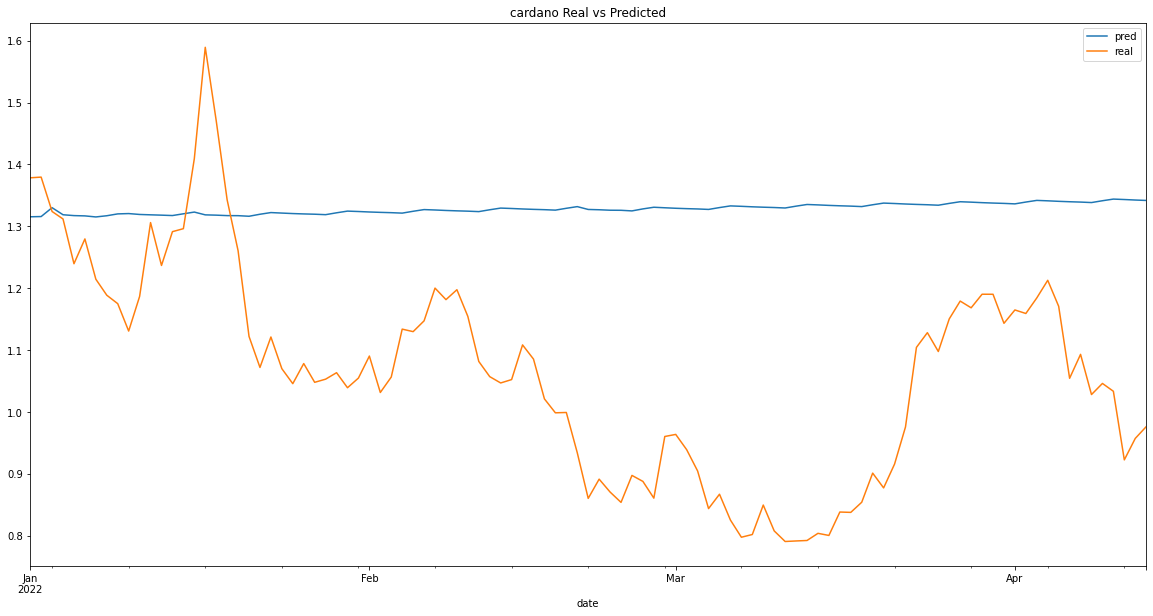

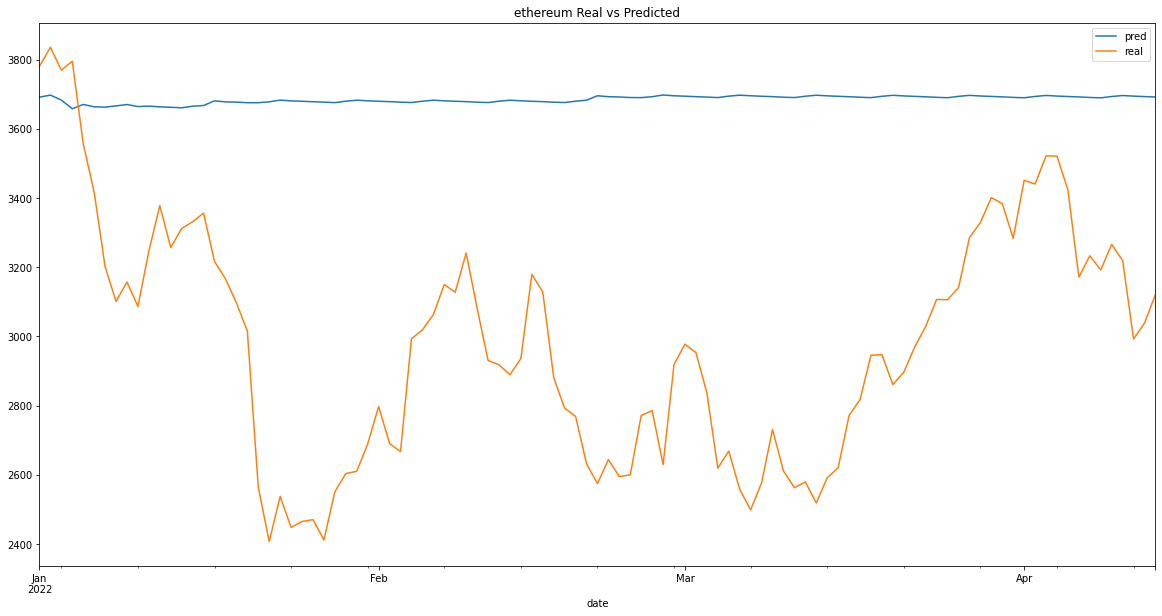

In [69]:
COINS = model_data.coin_id.unique()

for coin in COINS:
    coin_model_data = model_data.query(f"coin_id == '{coin}'").reset_index(drop=True)
    train_data = coin_model_data.query("date <= '2021-12-31'").reset_index(drop=True)
    test_data = coin_model_data.query("date > '2021-12-31'").reset_index(drop=True)
    
    X_train = train_data[['price', 'price_d1', 'price_d2', 'price_d3', 'price_d4', 'price_d5', 'price_d6', 'price_d7', 'weekend', 'us_holiday', 'cn_holiday']]
    y_train = train_data['price_f1']
    
    model = LinearRegression().fit(X_train.values, y_train)
    
    X_test = test_data[['price', 'price_d1', 'price_d2', 'price_d3', 'price_d4', 'price_d5', 'price_d6', 'price_d7', 'weekend', 'us_holiday', 'cn_holiday']]
    y_test = test_data['price_f1']
    
    # this is always going to be size 8. I'll initiate it with the current lagged prices
    lagged_predictions = [
        X_test.price[0],
        X_test.price_d1[0], 
        X_test.price_d2[0], 
        X_test.price_d3[0],
        X_test.price_d4[0],
        X_test.price_d5[0],
        X_test.price_d6[0],
        X_test.price_d7[0],
       ]
    
    # To store all the predictions
    predictions = []
    
    for i in range(len(X_test)):
        
        # Create features payload with the lagged predictions, and the proper 'weekend', 'us_holiday' and 'cn_holiday'
        features = lagged_predictions + [X_test.weekend[i], X_test.us_holiday[i], X_test.cn_holiday[i]]
        
        pred = model.predict(np.array([features]))
        
        # Shift the lagged_predictions, and include this new one as price
        lagged_predictions[7] = lagged_predictions[6]
        lagged_predictions[6] = lagged_predictions[5]
        lagged_predictions[5] = lagged_predictions[4]
        lagged_predictions[4] = lagged_predictions[3]
        lagged_predictions[3] = lagged_predictions[2]
        lagged_predictions[2] = lagged_predictions[1]
        lagged_predictions[1] = lagged_predictions[0]
        lagged_predictions[0] = pred[0]
        
        predictions.append(pred[0])
        
    X_test['pred'] = predictions
    X_test['real'] = y_test
    X_test['date'] = test_data['date']
    
        
    plot_data = X_test.set_index('date')
    ax = plot_data[['pred', 'real']].plot(
        figsize=(20, 10),
        title=f"{coin} Real vs Predicted",
    )
        
    plt.savefig(f"{MODEL_OUTPUT_PATH}/{coin}_model_plot.png")
    
                      
                          